In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler


# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../NewDatasets/processed_expression_4O.csv", index_col=0).T
meth_df = pd.read_csv("../NewDatasets/processed_methylation_4O.csv", index_col=0).T
cnv_df  = pd.read_csv("../NewDatasets/processed_cnv_4O.csv", index_col=0).T

# apply standard scaling to all data
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)

scaler_cnv = StandardScaler()
cnv_df = pd.DataFrame(
    scaler_cnv.fit_transform(cnv_df.T).T,
    index=cnv_df.index,
    columns=cnv_df.columns
)
scaler_gene = StandardScaler()
gene_df = pd.DataFrame(
    scaler_gene.fit_transform(gene_df.T).T,
    index=gene_df.index,
    columns=gene_df.columns
)

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")

After transpose - Shapes (samples x features):
gene_df: (265, 44750)
meth_df: (269, 419546)
cnv_df: (248, 56751)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
phenotype_df = pd.read_csv("../NewDatasets/phenotype_data_clean_FXS_MOFA_3Omics.csv", index_col=0)
# Align samples across all three omics and phenotype data
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index).intersection(phenotype_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]
phenotype_df = phenotype_df.loc[common]

print("Shapes after alignment:", gene_df.shape, meth_df.shape, cnv_df.shape, phenotype_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)


Shapes: (265, 44750) (269, 419546) (248, 56751)
Shapes after alignment: (205, 44750) (205, 419546) (205, 56751) (205, 78)


In [4]:
def Split(data):
    from sklearn.model_selection import train_test_split
    import numpy as np
    # Load subtype labels
    labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

    # Align labels with our data
    common_samples = data.index.intersection(labels_df.index)
    print(f"Samples with labels: {len(common_samples)}")

    # Filter data and labels to common samples
    labels = labels_df.loc[common_samples].values.ravel()
    # Prepare features and labels
    X = data  # Fused latent features
    y = labels  # Cancer subtype labels

    print("="*70)
    print("STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE")
    print("="*70)
    print(f"\n📊 Total samples: {len(X)}")
    print(f"\n🔬 Disease subtype distribution:")

    # Get unique disease subtypes
    unique_subtypes = np.unique(y)
    for subtype_idx in unique_subtypes:
        count = np.sum(y == subtype_idx)
        print(f"   - Subtype {subtype_idx}: {count} samples")

    # ====================================================================
    # Split each disease subtype 80/20, then merge
    # ====================================================================
    print(f"\n{'='*70}")
    print("🔹 Train/Test Split - Stratified by Disease:")
    print(f"{'='*70}")

    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    for subtype_idx in unique_subtypes:
        # Get samples for this subtype
        subtype_mask = (y == subtype_idx)
        X_subtype = X[subtype_mask]
        y_subtype = y[subtype_mask]
        
        # Split this subtype 80/20
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
            X_subtype, y_subtype, test_size=0.2, random_state=42
        )
        
        X_train_list.append(X_train_sub)
        X_test_list.append(X_test_sub)
        y_train_list.append(y_train_sub)
        y_test_list.append(y_test_sub)
        
        print(f"   Subtype {subtype_idx}:")
        print(f"      Train: {len(X_train_sub)} samples ({len(X_train_sub)/len(X_subtype)*100:.1f}%)")
        print(f"      Test:  {len(X_test_sub)} samples ({len(X_test_sub)/len(X_subtype)*100:.1f}%)")

    # Merge all subtypes
    X_train = np.vstack(X_train_list)
    X_test = np.vstack(X_test_list)
    y_train = np.concatenate(y_train_list)
    y_test = np.concatenate(y_test_list)

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


In [8]:
class LowRankHyperNetwork(nn.Module):
    """
    Low-rank hypernetwork that generates weights efficiently using factorization.
    Instead of generating W directly (in_dim × out_dim), generates:
    W = U @ V where U is (in_dim × rank) and V is (rank × out_dim)
    This dramatically reduces memory for high-dimensional inputs.
    """
    def __init__(self, embedding_dim, hidden_dim, in_features, out_features, rank=16):
        super(LowRankHyperNetwork, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        
        # Shared backbone
        self.backbone = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Generate low-rank factors instead of full weight matrix
        # U: (in_features × rank), V: (rank × out_features)
        self.U_generator = nn.Linear(hidden_dim, in_features * rank)
        self.V_generator = nn.Linear(hidden_dim, rank * out_features)
        self.bias_generator = nn.Linear(hidden_dim, out_features)
        
        # Scaling factor
        self.scale = nn.Parameter(torch.ones(1) * 0.1)
    
    def forward(self, embedding):
        features = self.backbone(embedding)
        
        # Generate low-rank factors
        U = self.U_generator(features).view(self.in_features, self.rank)
        V = self.V_generator(features).view(self.rank, self.out_features)
        
        # Reconstruct weight matrix: W = U @ V (transposed for F.linear)
        weight = (U @ V).T * self.scale  # (out_features, in_features)
        bias = self.bias_generator(features)
        
        return weight, bias


class HyperEncoder(nn.Module):
    """
    Memory-efficient encoder using low-rank hypernetwork-generated weights.
    Only the first layer uses hypernetwork (most benefit for high-dim input).
    Subsequent layers use standard learnable weights.
    """
    def __init__(self, input_dim, hidden_dims, latent_dim, embedding_dim, 
                 hyper_hidden_dim=64, rank=16, dropout=0.3):
        super(HyperEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Hypernetwork only for the first (high-dimensional) layer
        self.hyper_layer = LowRankHyperNetwork(
            embedding_dim=embedding_dim,
            hidden_dim=hyper_hidden_dim,
            in_features=input_dim,
            out_features=hidden_dims[0],
            rank=rank
        )
        
        # Standard layers for the rest (much smaller, no need for hypernetwork)
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        prev_dim = hidden_dims[0]
        for hidden_dim in hidden_dims[1:]:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            prev_dim = hidden_dim
        
        # Final layer to latent space
        self.final_layer = nn.Linear(prev_dim, latent_dim)
        self.first_bn = nn.BatchNorm1d(hidden_dims[0])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, embedding):
        # First layer: use hypernetwork-generated weights
        weight, bias = self.hyper_layer(embedding)
        x = F.linear(x, weight, bias)
        x = self.first_bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Subsequent layers: standard weights
        for layer, bn in zip(self.layers, self.batch_norms):
            x = layer(x)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Final projection
        z = self.final_layer(x)
        return z


class HyperDecoder(nn.Module):
    """Standard decoder (low-dimensional, no hypernetwork needed)."""
    def __init__(self, latent_dim, hidden_dims, output_dim, dropout=0.3):
        super(HyperDecoder, self).__init__()
        
        layers = []
        prev_dim = latent_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.decoder = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.decoder(z)


class HyperDNN(nn.Module):
    """
    Memory-Efficient HyperDNN for Multi-Omics Integration.
    
    Uses low-rank hypernetworks to generate modality-specific encoder weights
    based on learnable omics-type embeddings.
    """
    def __init__(self, input_dims, latent_dim=32, hyper_hidden_dim=64, 
                 embedding_dim=16, encoder_hidden_dims=[128, 64], 
                 rank=16, dropout=0.4):
        """
        Args:
            input_dims: Dict mapping omics names to input dimensions
            latent_dim: Dimension of the shared latent space
            hyper_hidden_dim: Hidden dimension of the hypernetwork
            embedding_dim: Dimension of omics-type embeddings
            encoder_hidden_dims: Hidden layer dimensions for encoders
            rank: Rank for low-rank weight approximation
            dropout: Dropout rate
        """
        super(HyperDNN, self).__init__()
        
        self.input_dims = input_dims
        self.latent_dim = latent_dim
        self.omics_names = list(input_dims.keys())
        self.num_omics = len(self.omics_names)
        self.embedding_dim = embedding_dim
        
        # Learnable omics-type embeddings
        self.omics_embeddings = nn.Embedding(self.num_omics, embedding_dim)
        
        # Create encoders and decoders for each omics type
        self.encoders = nn.ModuleDict()
        self.decoders = nn.ModuleDict()
        
        for name, input_dim in input_dims.items():
            # Encoder with hypernetwork for first layer
            self.encoders[name] = HyperEncoder(
                input_dim=input_dim,
                hidden_dims=encoder_hidden_dims,
                latent_dim=latent_dim,
                embedding_dim=embedding_dim,
                hyper_hidden_dim=hyper_hidden_dim,
                rank=rank,
                dropout=dropout
            )
            
            # Standard decoder
            self.decoders[name] = HyperDecoder(
                latent_dim=latent_dim,
                hidden_dims=list(reversed(encoder_hidden_dims)),
                output_dim=input_dim,
                dropout=dropout
            )
        
        # Register omics indices as buffer (stays on correct device)
        for i, name in enumerate(self.omics_names):
            self.register_buffer(f'omics_idx_{name}', torch.tensor(i))
    
    def get_omics_embedding(self, omics_name, device):
        """Get the embedding for an omics type on the correct device."""
        idx = getattr(self, f'omics_idx_{omics_name}')
        return self.omics_embeddings(idx)
    
    def encode(self, x, omics_name):
        """Encode input from a specific omics type."""
        embedding = self.get_omics_embedding(omics_name, x.device)
        z = self.encoders[omics_name](x, embedding)
        return z
    
    def decode(self, z, omics_name):
        """Decode latent representation to a specific omics type."""
        return self.decoders[omics_name](z)
    
    def forward(self, inputs):
        """
        Forward pass for all omics types.
        
        Args:
            inputs: Dict mapping omics names to input tensors
        
        Returns:
            latents: Dict of latent representations
            reconstructions: Dict of reconstructed outputs
        """
        latents = {}
        reconstructions = {}
        
        for name, x in inputs.items():
            z = self.encode(x, name)
            recon = self.decode(z, name)
            latents[name] = z
            reconstructions[name] = recon
        
        return latents, reconstructions
    
    def get_fused_latent(self, inputs, fusion='concat'):
        """Get fused latent representation from all omics."""
        latents, _ = self.forward(inputs)
        latent_list = [latents[name] for name in self.omics_names]
        
        if fusion == 'concat':
            return torch.cat(latent_list, dim=1)
        elif fusion == 'mean':
            return torch.stack(latent_list, dim=0).mean(dim=0)
        else:
            raise ValueError(f"Unknown fusion method: {fusion}")



In [9]:
# ============================================================================
# HyperDNN: Hypernetwork-based Deep Neural Network for Multi-Omics Integration
# ============================================================================
# Uses LOW-RANK hypernetwork to efficiently generate modality-specific weights
# This avoids memory issues with high-dimensional omics data
# ============================================================================

class LowRankHyperNetwork(nn.Module):
    """
    Low-rank hypernetwork that generates weights efficiently using factorization.
    Instead of generating W directly (in_dim × out_dim), generates:
    W = U @ V where U is (in_dim × rank) and V is (rank × out_dim)
    This dramatically reduces memory for high-dimensional inputs.
    """
    def __init__(self, embedding_dim, hidden_dim, in_features, out_features, rank=16):
        super(LowRankHyperNetwork, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        
        # Shared backbone
        self.backbone = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Generate low-rank factors instead of full weight matrix
        # U: (in_features × rank), V: (rank × out_features)
        self.U_generator = nn.Linear(hidden_dim, in_features * rank)
        self.V_generator = nn.Linear(hidden_dim, rank * out_features)
        self.bias_generator = nn.Linear(hidden_dim, out_features)
        
        # Scaling factor
        self.scale = nn.Parameter(torch.ones(1) * 0.1)
    
    def forward(self, embedding):
        features = self.backbone(embedding)
        
        # Generate low-rank factors
        U = self.U_generator(features).view(self.in_features, self.rank)
        V = self.V_generator(features).view(self.rank, self.out_features)
        
        # Reconstruct weight matrix: W = U @ V (transposed for F.linear)
        weight = (U @ V).T * self.scale  # (out_features, in_features)
        bias = self.bias_generator(features)
        
        return weight, bias


class HyperEncoder(nn.Module):
    """
    Memory-efficient encoder using low-rank hypernetwork-generated weights.
    Only the first layer uses hypernetwork (most benefit for high-dim input).
    Subsequent layers use standard learnable weights.
    """
    def __init__(self, input_dim, hidden_dims, latent_dim, embedding_dim, 
                 hyper_hidden_dim=64, rank=16, dropout=0.3):
        super(HyperEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Hypernetwork only for the first (high-dimensional) layer
        self.hyper_layer = LowRankHyperNetwork(
            embedding_dim=embedding_dim,
            hidden_dim=hyper_hidden_dim,
            in_features=input_dim,
            out_features=hidden_dims[0],
            rank=rank
        )
        
        # Standard layers for the rest (much smaller, no need for hypernetwork)
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        prev_dim = hidden_dims[0]
        for hidden_dim in hidden_dims[1:]:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            prev_dim = hidden_dim
        
        # Final layer to latent space
        self.final_layer = nn.Linear(prev_dim, latent_dim)
        self.first_bn = nn.BatchNorm1d(hidden_dims[0])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, embedding):
        # First layer: use hypernetwork-generated weights
        weight, bias = self.hyper_layer(embedding)
        x = F.linear(x, weight, bias)
        x = self.first_bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Subsequent layers: standard weights
        for layer, bn in zip(self.layers, self.batch_norms):
            x = layer(x)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Final projection
        z = self.final_layer(x)
        return z


class HyperDecoder(nn.Module):
    """Standard decoder (low-dimensional, no hypernetwork needed)."""
    def __init__(self, latent_dim, hidden_dims, output_dim, dropout=0.3):
        super(HyperDecoder, self).__init__()
        
        layers = []
        prev_dim = latent_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.decoder = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.decoder(z)


class HyperDNN(nn.Module):
    """
    Memory-Efficient HyperDNN for Multi-Omics Integration.
    
    Uses low-rank hypernetworks to generate modality-specific encoder weights
    based on learnable omics-type embeddings.
    """
    def __init__(self, input_dims, latent_dim=32, hyper_hidden_dim=64, 
                 embedding_dim=16, encoder_hidden_dims=[128, 64], 
                 rank=16, dropout=0.4):
        """
        Args:
            input_dims: Dict mapping omics names to input dimensions
            latent_dim: Dimension of the shared latent space
            hyper_hidden_dim: Hidden dimension of the hypernetwork
            embedding_dim: Dimension of omics-type embeddings
            encoder_hidden_dims: Hidden layer dimensions for encoders
            rank: Rank for low-rank weight approximation
            dropout: Dropout rate
        """
        super(HyperDNN, self).__init__()
        
        self.input_dims = input_dims
        self.latent_dim = latent_dim
        self.omics_names = list(input_dims.keys())
        self.num_omics = len(self.omics_names)
        self.embedding_dim = embedding_dim
        
        # Learnable omics-type embeddings
        self.omics_embeddings = nn.Embedding(self.num_omics, embedding_dim)
        
        # Create encoders and decoders for each omics type
        self.encoders = nn.ModuleDict()
        self.decoders = nn.ModuleDict()
        
        for name, input_dim in input_dims.items():
            # Encoder with hypernetwork for first layer
            self.encoders[name] = HyperEncoder(
                input_dim=input_dim,
                hidden_dims=encoder_hidden_dims,
                latent_dim=latent_dim,
                embedding_dim=embedding_dim,
                hyper_hidden_dim=hyper_hidden_dim,
                rank=rank,
                dropout=dropout
            )
            
            # Standard decoder
            self.decoders[name] = HyperDecoder(
                latent_dim=latent_dim,
                hidden_dims=list(reversed(encoder_hidden_dims)),
                output_dim=input_dim,
                dropout=dropout
            )
        
        # Register omics indices as buffer (stays on correct device)
        for i, name in enumerate(self.omics_names):
            self.register_buffer(f'omics_idx_{name}', torch.tensor(i))
    
    def get_omics_embedding(self, omics_name, device):
        """Get the embedding for an omics type on the correct device."""
        idx = getattr(self, f'omics_idx_{omics_name}')
        return self.omics_embeddings(idx)
    
    def encode(self, x, omics_name):
        """Encode input from a specific omics type."""
        embedding = self.get_omics_embedding(omics_name, x.device)
        z = self.encoders[omics_name](x, embedding)
        return z
    
    def decode(self, z, omics_name):
        """Decode latent representation to a specific omics type."""
        return self.decoders[omics_name](z)
    
    def forward(self, inputs):
        """
        Forward pass for all omics types.
        
        Args:
            inputs: Dict mapping omics names to input tensors
        
        Returns:
            latents: Dict of latent representations
            reconstructions: Dict of reconstructed outputs
        """
        latents = {}
        reconstructions = {}
        
        for name, x in inputs.items():
            z = self.encode(x, name)
            recon = self.decode(z, name)
            latents[name] = z
            reconstructions[name] = recon
        
        return latents, reconstructions
    
    def get_fused_latent(self, inputs, fusion='concat'):
        """Get fused latent representation from all omics."""
        latents, _ = self.forward(inputs)
        latent_list = [latents[name] for name in self.omics_names]
        
        if fusion == 'concat':
            return torch.cat(latent_list, dim=1)
        elif fusion == 'mean':
            return torch.stack(latent_list, dim=0).mean(dim=0)
        else:
            raise ValueError(f"Unknown fusion method: {fusion}")


# ------------------ Training with validation & early stopping ------------------
def train_hyperdnn(model, train_inputs, val_inputs, epochs=3000, patience=30, lr=1e-4):
    """Train HyperDNN with validation and early stopping."""
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        _, train_recons = model(train_inputs)
        
        train_loss = 0
        for name in train_inputs.keys():
            train_loss += criterion(train_recons[name], train_inputs[name])
        train_loss /= len(train_inputs)

        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            _, val_recons = model(val_inputs)
            val_loss = 0
            for name in val_inputs.keys():
                val_loss += criterion(val_recons[name], val_inputs[name])
            val_loss /= len(val_inputs)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        scheduler.step(val_loss)

        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss.item():.4f} | Val: {val_loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("HyperDNN Training Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return model

In [10]:
# ============================================================================
# OPTUNA HYPERPARAMETER OPTIMIZATION
# ============================================================================
# Automatically finds the best hyperparameters for HyperDNN using Bayesian
# optimization with Tree-structured Parzen Estimator (TPE).
# ============================================================================

import optuna
from optuna.trial import TrialState
import warnings
warnings.filterwarnings('ignore')


def create_hyperdnn_model(trial, input_dims, device):
    """
    Create a HyperDNN model with hyperparameters suggested by Optuna.
    
    Args:
        trial: Optuna trial object
        input_dims: Dict mapping omics names to input dimensions
        device: Torch device
    
    Returns:
        model: HyperDNN model with suggested hyperparameters
    """
    # Suggest hyperparameters
    latent_dim = trial.suggest_categorical('latent_dim', [16, 32, 48, 64])
    
    # Encoder hidden dimensions (2-3 layers)
    n_encoder_layers = trial.suggest_int('n_encoder_layers', 2, 3)
    encoder_hidden_dims = []
    for i in range(n_encoder_layers):
        dim = trial.suggest_categorical(f'encoder_hidden_{i}', [64, 128, 256, 512])
        encoder_hidden_dims.append(dim)
    # Ensure decreasing dimensions
    encoder_hidden_dims = sorted(encoder_hidden_dims, reverse=True)
    
    # Hypernetwork parameters
    hyper_hidden_dim = trial.suggest_categorical('hyper_hidden_dim', [32, 64, 128])
    embedding_dim = trial.suggest_categorical('embedding_dim', [8, 16, 32])
    rank = trial.suggest_categorical('rank', [8, 16, 32, 48])
    
    # Regularization
    dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
    
    # Create model
    model = HyperDNN(
        input_dims=input_dims,
        latent_dim=latent_dim,
        hyper_hidden_dim=hyper_hidden_dim,
        embedding_dim=embedding_dim,
        encoder_hidden_dims=encoder_hidden_dims,
        rank=rank,
        dropout=dropout
    ).to(device)
    
    return model


def train_hyperdnn_for_optuna(model, train_inputs, val_inputs, trial, 
                               epochs=500, patience=20):
    """
    Training function optimized for Optuna with early stopping and pruning.
    
    Args:
        model: HyperDNN model
        train_inputs: Training data dict
        val_inputs: Validation data dict
        trial: Optuna trial for pruning
        epochs: Maximum training epochs
        patience: Early stopping patience
    
    Returns:
        best_val_loss: Best validation loss achieved
    """
    # Suggest optimizer hyperparameters
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    criterion = nn.MSELoss()
    
    best_val_loss = np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        _, train_recons = model(train_inputs)
        
        train_loss = 0
        for name in train_inputs.keys():
            train_loss += criterion(train_recons[name], train_inputs[name])
        train_loss /= len(train_inputs)
        
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            _, val_recons = model(val_inputs)
            val_loss = 0
            for name in val_inputs.keys():
                val_loss += criterion(val_recons[name], val_inputs[name])
            val_loss /= len(val_inputs)
        
        scheduler.step(val_loss)
        
        # Report to Optuna for pruning
        trial.report(val_loss.item(), epoch)
        
        # Handle pruning (stop unpromising trials early)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_loss


def objective(trial, input_dims, train_inputs, val_inputs, device):
    """
    Optuna objective function for HyperDNN hyperparameter optimization.
    
    Args:
        trial: Optuna trial
        input_dims: Dict mapping omics names to input dimensions
        train_inputs: Training data dict
        val_inputs: Validation data dict
        device: Torch device
    
    Returns:
        val_loss: Validation loss (to minimize)
    """
    # Create model with suggested hyperparameters
    model = create_hyperdnn_model(trial, input_dims, device)
    
    # Train and evaluate
    val_loss = train_hyperdnn_for_optuna(
        model, train_inputs, val_inputs, trial,
        epochs=500, patience=20
    )
    
    return val_loss


def run_optuna_optimization(input_dims, train_inputs, val_inputs, device,
                           n_trials=50, timeout=3600, study_name="hyperdnn_optimization"):
    """
    Run Optuna hyperparameter optimization for HyperDNN.
    
    Args:
        input_dims: Dict mapping omics names to input dimensions
        train_inputs: Training data dict
        val_inputs: Validation data dict
        device: Torch device
        n_trials: Number of optimization trials
        timeout: Maximum optimization time in seconds
        study_name: Name for the study (for persistence)
    
    Returns:
        study: Optuna study object with results
        best_model: Best HyperDNN model found
    """
    print("="*70)
    print("OPTUNA HYPERPARAMETER OPTIMIZATION FOR HYPERDNN")
    print("="*70)
    print(f"\nConfiguration:")
    print(f"  Number of trials: {n_trials}")
    print(f"  Timeout: {timeout}s ({timeout/60:.1f} min)")
    print(f"  Device: {device}")
    
    # Create Optuna study with TPE sampler and MedianPruner
    sampler = optuna.samplers.TPESampler(seed=42)
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=50,
        interval_steps=10
    )
    
    study = optuna.create_study(
        study_name=study_name,
        direction="minimize",  # Minimize validation loss
        sampler=sampler,
        pruner=pruner
    )
    
    # Create objective function with fixed arguments
    def objective_wrapper(trial):
        return objective(trial, input_dims, train_inputs, val_inputs, device)
    
    # Run optimization
    print("\nStarting optimization...")
    print("-"*70)
    
    study.optimize(
        objective_wrapper,
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True,
        gc_after_trial=True  # Clean up GPU memory
    )
    
    # Print results
    print("\n" + "="*70)
    print("OPTIMIZATION RESULTS")
    print("="*70)
    
    # Trial statistics
    pruned_trials = len([t for t in study.trials if t.state == TrialState.PRUNED])
    complete_trials = len([t for t in study.trials if t.state == TrialState.COMPLETE])
    
    print(f"\nTrial Statistics:")
    print(f"  Completed trials: {complete_trials}")
    print(f"  Pruned trials: {pruned_trials}")
    print(f"  Total trials: {len(study.trials)}")
    
    # Best trial
    print(f"\nBest Trial:")
    print(f"  Value (Val Loss): {study.best_trial.value:.6f}")
    print(f"  Trial Number: {study.best_trial.number}")
    
    print(f"\nBest Hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"  {key}: {value}")
    
    # Reconstruct best model
    print("\nReconstructing best model...")
    best_params = study.best_trial.params
    
    # Build encoder hidden dims from best params
    n_layers = best_params['n_encoder_layers']
    encoder_hidden_dims = sorted(
        [best_params[f'encoder_hidden_{i}'] for i in range(n_layers)],
        reverse=True
    )
    
    best_model = HyperDNN(
        input_dims=input_dims,
        latent_dim=best_params['latent_dim'],
        hyper_hidden_dim=best_params['hyper_hidden_dim'],
        embedding_dim=best_params['embedding_dim'],
        encoder_hidden_dims=encoder_hidden_dims,
        rank=best_params['rank'],
        dropout=best_params['dropout']
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in best_model.parameters())
    print(f"\nBest Model Parameters: {total_params:,}")
    
    return study, best_model


def visualize_optuna_results(study):
    """
    Visualize Optuna optimization results.
    
    Args:
        study: Completed Optuna study
    """
    try:
        import optuna.visualization as vis
        
        print("\n" + "="*70)
        print("OPTIMIZATION VISUALIZATION")
        print("="*70)
        
        # Create visualizations
        fig_history = vis.plot_optimization_history(study)
        fig_history.show()
        
        fig_importance = vis.plot_param_importances(study)
        fig_importance.show()
        
        fig_parallel = vis.plot_parallel_coordinate(study)
        fig_parallel.show()
        
        fig_contour = vis.plot_contour(study, params=['latent_dim', 'rank'])
        fig_contour.show()
        
    except ImportError:
        # Fallback to matplotlib if plotly not available
        print("\nPlotting optimization history with matplotlib...")
        
        trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
        values = [t.value for t in trials]
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Optimization history
        axes[0].plot(range(len(values)), values, 'b-o', alpha=0.6, markersize=4)
        best_values = [min(values[:i+1]) for i in range(len(values))]
        axes[0].plot(range(len(best_values)), best_values, 'r-', linewidth=2, label='Best Value')
        axes[0].set_xlabel('Trial')
        axes[0].set_ylabel('Validation Loss')
        axes[0].set_title('Optimization History')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Hyperparameter importance (simple estimate)
        param_values = {}
        for t in trials:
            for k, v in t.params.items():
                if k not in param_values:
                    param_values[k] = []
                param_values[k].append((v, t.value))
        
        # Calculate correlation with loss for numeric params
        importances = {}
        for param, vals in param_values.items():
            try:
                xs = [v[0] for v in vals]
                ys = [v[1] for v in vals]
                if isinstance(xs[0], (int, float)):
                    from scipy.stats import pearsonr
                    corr, _ = pearsonr(xs, ys)
                    importances[param] = abs(corr)
            except:
                pass
        
        if importances:
            sorted_params = sorted(importances.items(), key=lambda x: x[1], reverse=True)
            params, imps = zip(*sorted_params[:8])
            axes[1].barh(params, imps, color='steelblue', alpha=0.7)
            axes[1].set_xlabel('Importance (correlation with loss)')
            axes[1].set_title('Hyperparameter Importance')
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


def get_optimized_hyperdnn(input_dims, train_inputs, val_inputs, device,
                          n_trials=50, timeout=3600, retrain_epochs=3000):
    """
    Complete pipeline: Run Optuna optimization and retrain best model fully.
    
    Args:
        input_dims: Dict mapping omics names to input dimensions
        train_inputs: Training data dict
        val_inputs: Validation data dict
        device: Torch device
        n_trials: Number of Optuna trials
        timeout: Optimization timeout in seconds
        retrain_epochs: Epochs for final retraining
    
    Returns:
        best_model: Fully trained best HyperDNN model
        study: Optuna study for analysis
    """
    # Run optimization
    study, best_model = run_optuna_optimization(
        input_dims, train_inputs, val_inputs, device,
        n_trials=n_trials, timeout=timeout
    )
    
    # Visualize results
    visualize_optuna_results(study)
    
    # Retrain best model with full epochs
    print("\n" + "="*70)
    print("RETRAINING BEST MODEL WITH FULL EPOCHS")
    print("="*70)
    
    best_lr = study.best_trial.params['learning_rate']
    best_model = train_hyperdnn(
        best_model, train_inputs, val_inputs,
        epochs=retrain_epochs, patience=50, lr=best_lr
    )
    
    return best_model, study



f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HYPERDNN: Low-Rank Hypernetwork for Multi-Omics Integration

Input dimensions:
  Gene Expression: 44750
  Methylation: 419546
  CNV: 56751

Using device: cuda

HyperDNN Architecture:
  Latent dimension: 32
  Hypernetwork hidden dim: 64
  Omics embedding dim: 16
  Encoder hidden layers: [128, 64]
  Low-rank: 16

Total parameters: 609,609,050
Trainable parameters: 609,609,050

Model device check:
  omics_embeddings.weight: cuda:0
  encoders.gene.hyper_layer.scale: cuda:0

Training samples: 164
Validation samples: 41

Training HyperDNN...
Epoch 1/3000 | Train: 1.2874 | Val: 1.0142 | LR: 1.00e-04
Epoch 50/3000 | Train: 1.0167 | Val: 0.9103 | LR: 1.00e-04
Epoch 100/3000 | Train: 0.8388 | Val: 0.7998 | LR: 1.00e-04
Epoch 150/3000 | Train: 0.7242 | Val: 0.6919 | LR: 1.00e-04
Epoch 200/3000 | Train: 0.6368 | Val: 0.5963 | LR: 1.00e-04
Epoch 250/3000 | Train: 0.5822 | Val: 0.5245 | LR: 1.00e-04
Epoch 300/3000 | Train: 0.5427 | Val: 0.4799 | LR: 1.00e-04
Epoch 350/3000 | Train: 0.5123 | Val: 0.4

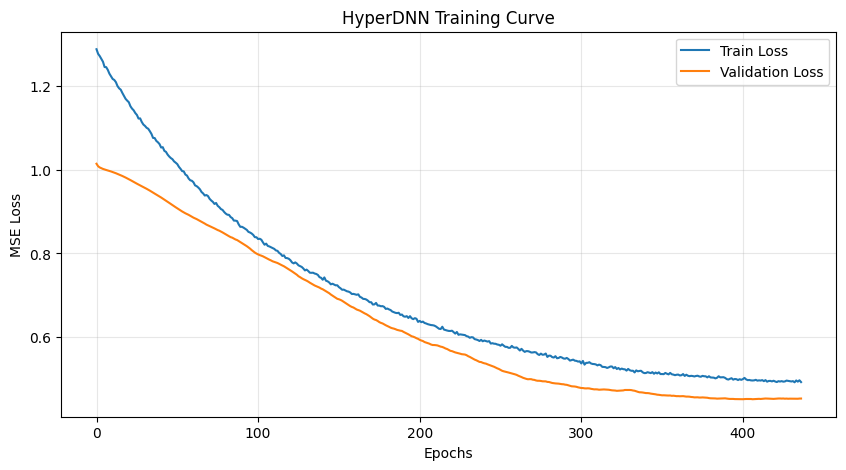


Extracting fused latent representations...

Latent representations:
  gene: torch.Size([205, 32])
  meth: torch.Size([205, 32])
  cnv: torch.Size([205, 32])

Fused latent shape: torch.Size([205, 96])


In [11]:
# ------------------ Initialize and Train HyperDNN ------------------
print("="*70)
print("HYPERDNN: Low-Rank Hypernetwork for Multi-Omics Integration")
print("="*70)

# Get dimensions
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]
print(f"\nInput dimensions:")
print(f"  Gene Expression: {gene_dim}")
print(f"  Methylation: {meth_dim}")
print(f"  CNV: {cnv_dim}")
print(f"\nUsing device: {device}")

# Define input dimensions
input_dims = {
    'gene': gene_dim,
    'meth': meth_dim,
    'cnv': cnv_dim
}

# Create HyperDNN model with memory-efficient settings
hyperdnn = HyperDNN(
    input_dims=input_dims,
    latent_dim=32,
    hyper_hidden_dim=64,
    embedding_dim=16,
    encoder_hidden_dims=[128, 64],  # Smaller hidden dims
    rank=16,  # Low-rank approximation
    dropout=0.4
).to(device)

print(f"\nHyperDNN Architecture:")
print(f"  Latent dimension: 32")
print(f"  Hypernetwork hidden dim: 64")
print(f"  Omics embedding dim: 16")
print(f"  Encoder hidden layers: [128, 64]")
print(f"  Low-rank: 16")

# Count parameters
total_params = sum(p.numel() for p in hyperdnn.parameters())
trainable_params = sum(p.numel() for p in hyperdnn.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Verify model is on GPU
print(f"\nModel device check:")
for name, param in list(hyperdnn.named_parameters())[:2]:
    print(f"  {name}: {param.device}")

# Prepare train/val splits
n_samples = gene.shape[0]
n_train = int(0.8 * n_samples)

train_inputs = {
    'gene': gene[:n_train],
    'meth': meth[:n_train],
    'cnv': cnv[:n_train]
}

val_inputs = {
    'gene': gene[n_train:],
    'meth': meth[n_train:],
    'cnv': cnv[n_train:]
}

print(f"\nTraining samples: {n_train}")
print(f"Validation samples: {n_samples - n_train}")

# Train the model
print("\n" + "="*70)
print("Training HyperDNN...")
print("="*70)
hyperdnn = train_hyperdnn(hyperdnn, train_inputs, val_inputs, epochs=3000, patience=30)

# ------------------ Extract latents & fuse ------------------
print("\n" + "="*70)
print("Extracting fused latent representations...")
print("="*70)

hyperdnn.eval()
all_inputs = {
    'gene': gene,
    'meth': meth,
    'cnv': cnv
}

with torch.no_grad():
    z_fused = hyperdnn.get_fused_latent(all_inputs, fusion='concat')
    latents, _ = hyperdnn(all_inputs)

print(f"\nLatent representations:")
for name, z in latents.items():
    print(f"  {name}: {z.shape}")
print(f"\nFused latent shape: {z_fused.shape}")


In [12]:

from sklearn.metrics import silhouette_score
import seaborn as sns

# ------------------ HyperDNN Diagnostics ------------------
def hyperdnn_reconstruction_error(model, train_inputs, val_inputs, device):
    """Compute and plot per-sample reconstruction errors for train/val."""
    
    def compute_errors(inputs):
        model.eval()
        with torch.no_grad():
            _, recons = model(inputs)
        
        errors = {}
        for name in inputs.keys():
            err = ((recons[name].cpu().numpy() - inputs[name].cpu().numpy())**2).mean(axis=1)
            errors[name] = err
        
        # Average across all omics
        avg_errors = np.mean([errors[name] for name in inputs.keys()], axis=0)
        return errors, avg_errors
    
    train_errors, train_avg = compute_errors(train_inputs)
    val_errors, val_avg = compute_errors(val_inputs)
    
    # Plot per-omics reconstruction errors
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    
    for idx, name in enumerate(train_inputs.keys()):
        sns.kdeplot(train_errors[name], label="Train", shade=True, ax=axes[idx])
        sns.kdeplot(val_errors[name], label="Validation", shade=True, ax=axes[idx])
        axes[idx].set_xlabel("Reconstruction Error")
        axes[idx].set_ylabel("Density")
        axes[idx].set_title(f"{name.upper()} Reconstruction Errors")
        axes[idx].legend()
    
    # Average errors
    sns.kdeplot(train_avg, label="Train", shade=True, ax=axes[3])
    sns.kdeplot(val_avg, label="Validation", shade=True, ax=axes[3])
    axes[3].set_xlabel("Reconstruction Error")
    axes[3].set_ylabel("Density")
    axes[3].set_title("Average Reconstruction Errors")
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Reconstruction Error Summary:")
    print("-" * 60)
    for name in train_inputs.keys():
        print(f"{name.upper()}:")
        print(f"  Train Median: {np.median(train_errors[name]):.4f}")
        print(f"  Val Median:   {np.median(val_errors[name]):.4f}")
    print(f"\nAVERAGE:")
    print(f"  Train Median: {np.median(train_avg):.4f}")
    print(f"  Val Median:   {np.median(val_avg):.4f}")
    
    return train_errors, val_errors


def visualize_omics_embeddings(model):
    """Visualize the learned omics-type embeddings."""
    model.eval()
    
    embeddings = model.omics_embeddings.weight.detach().cpu().numpy()
    omics_names = model.omics_names
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Heatmap of embeddings
    im = axes[0].imshow(embeddings, aspect='auto', cmap='coolwarm')
    axes[0].set_yticks(range(len(omics_names)))
    axes[0].set_yticklabels([name.upper() for name in omics_names])
    axes[0].set_xlabel("Embedding Dimension")
    axes[0].set_title("Omics Type Embeddings")
    plt.colorbar(im, ax=axes[0])
    
    # Pairwise cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(embeddings)
    
    im2 = axes[1].imshow(sim_matrix, cmap='Blues', vmin=-1, vmax=1)
    axes[1].set_xticks(range(len(omics_names)))
    axes[1].set_yticks(range(len(omics_names)))
    axes[1].set_xticklabels([name.upper() for name in omics_names])
    axes[1].set_yticklabels([name.upper() for name in omics_names])
    axes[1].set_title("Omics Embedding Similarity")
    
    # Add text annotations
    for i in range(len(omics_names)):
        for j in range(len(omics_names)):
            axes[1].text(j, i, f'{sim_matrix[i, j]:.2f}', 
                        ha='center', va='center', fontsize=10)
    
    plt.colorbar(im2, ax=axes[1])
    plt.tight_layout()
    plt.show()


def compare_latent_spaces(model, inputs):
    """Compare latent spaces from different omics types."""
    model.eval()
    with torch.no_grad():
        latents, _ = model(inputs)
    
    # Get latent representations
    z_gene = latents['gene'].cpu().numpy()
    z_meth = latents['meth'].cpu().numpy()
    z_cnv = latents['cnv'].cpu().numpy()
    
    # Compute correlations between latent spaces
    from scipy.stats import pearsonr
    
    print("Latent Space Correlations (mean across dimensions):")
    print("-" * 50)
    
    corrs = {
        'Gene-Meth': np.mean([pearsonr(z_gene[:, i], z_meth[:, i])[0] for i in range(z_gene.shape[1])]),
        'Gene-CNV': np.mean([pearsonr(z_gene[:, i], z_cnv[:, i])[0] for i in range(z_gene.shape[1])]),
        'Meth-CNV': np.mean([pearsonr(z_meth[:, i], z_cnv[:, i])[0] for i in range(z_meth.shape[1])])
    }
    
    for pair, corr in corrs.items():
        print(f"  {pair}: {corr:.3f}")
    
    return corrs



HYPERDNN DIAGNOSTICS

1. Reconstruction Error Analysis
--------------------------------------------------


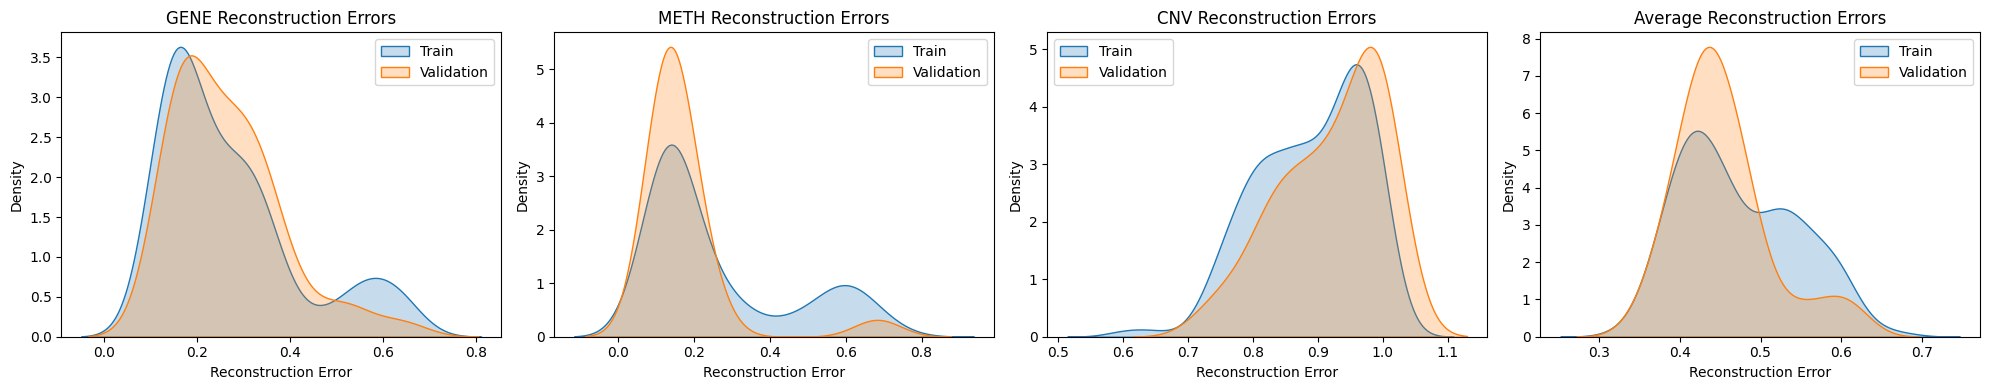

Reconstruction Error Summary:
------------------------------------------------------------
GENE:
  Train Median: 0.2246
  Val Median:   0.2535
METH:
  Train Median: 0.1562
  Val Median:   0.1353
CNV:
  Train Median: 0.8966
  Val Median:   0.9396

AVERAGE:
  Train Median: 0.4571
  Val Median:   0.4371

2. Omics Type Embeddings
--------------------------------------------------


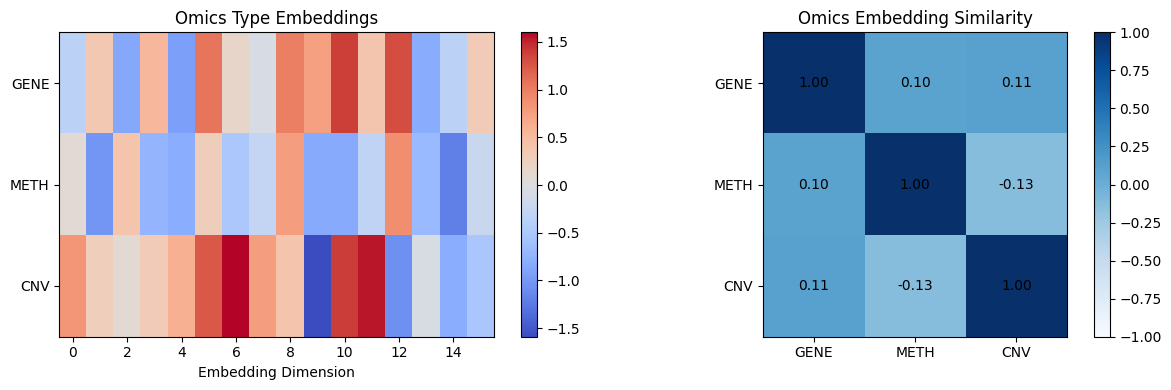


3. Latent Space Comparison
--------------------------------------------------
Latent Space Correlations (mean across dimensions):
--------------------------------------------------
  Gene-Meth: -0.001
  Gene-CNV: 0.011
  Meth-CNV: 0.012

4. Clustering Sanity Check
--------------------------------------------------
Silhouette Score on fused latents: 0.389
Silhouette Score: 0.388604998588562
Calinski-Harabasz Score: 149.67709350585938
Davies-Bouldin Score: 0.958852888909421


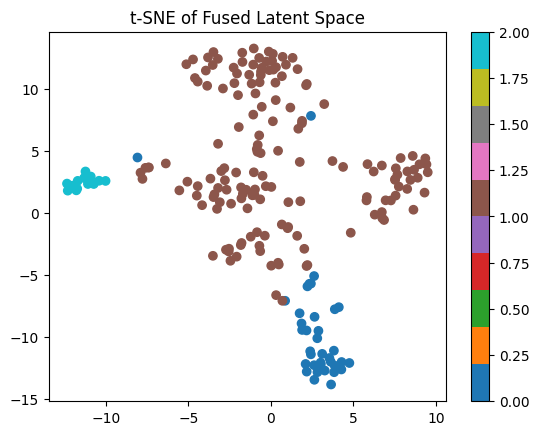

Samples with labels: 205
Final data shape: (205, 96)
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]
Embeddings shape: (205, 96)
Labels shape: (205,)
Unique labels: [0 1 2 3]
Computing PCA...
Computing t-SNE...


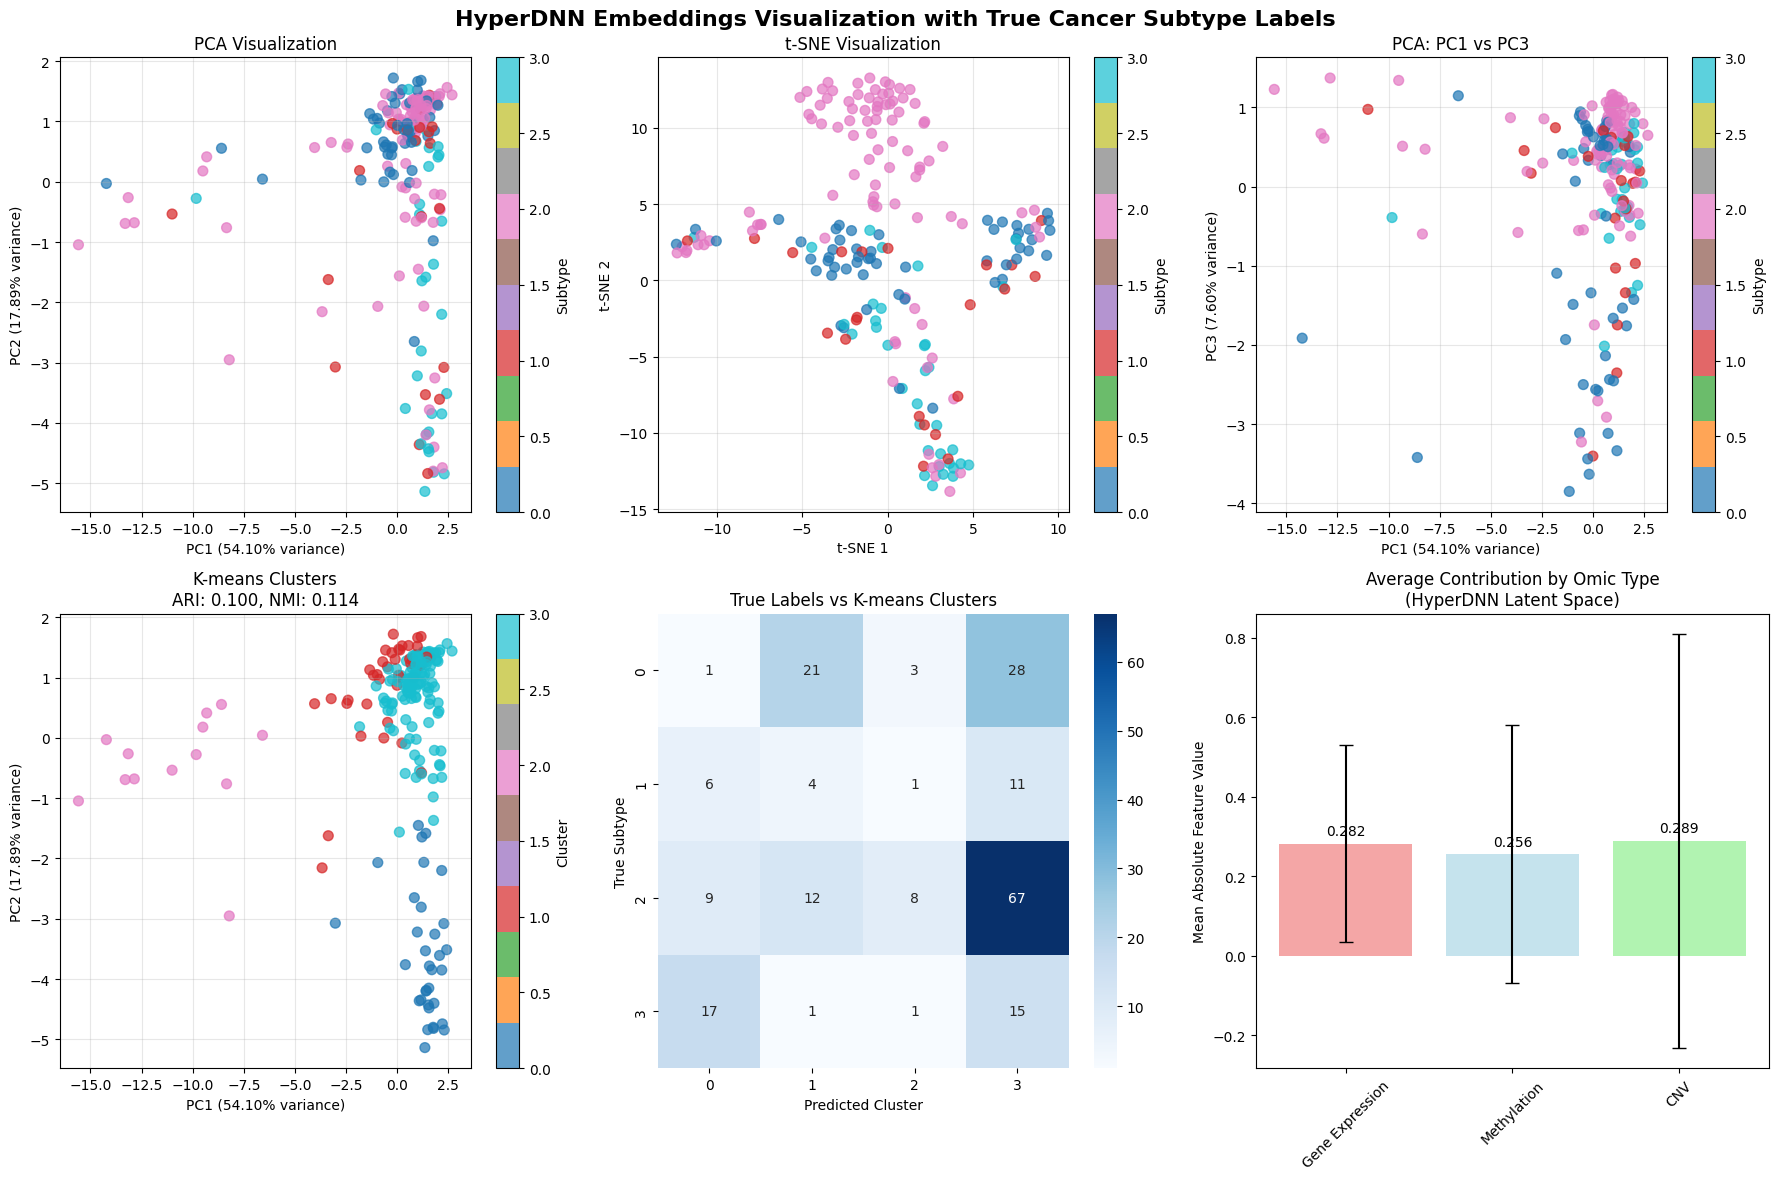

In [13]:

# ------------------ Run Diagnostics ------------------
print("="*70)
print("HYPERDNN DIAGNOSTICS")
print("="*70)

# 1. Check reconstruction errors
print("\n1. Reconstruction Error Analysis")
print("-"*50)
train_inputs_diag = {'gene': gene[:n_train], 'meth': meth[:n_train], 'cnv': cnv[:n_train]}
val_inputs_diag = {'gene': gene[n_train:], 'meth': meth[n_train:], 'cnv': cnv[n_train:]}
train_errs, val_errs = hyperdnn_reconstruction_error(hyperdnn, train_inputs_diag, val_inputs_diag, device)

# 2. Visualize omics embeddings
print("\n2. Omics Type Embeddings")
print("-"*50)
visualize_omics_embeddings(hyperdnn)

# 3. Compare latent spaces
print("\n3. Latent Space Comparison")
print("-"*50)
all_inputs_diag = {'gene': gene, 'meth': meth, 'cnv': cnv}
corrs = compare_latent_spaces(hyperdnn, all_inputs_diag)

# 4. Clustering sanity check on fused latents
print("\n4. Clustering Sanity Check")
print("-"*50)
from sklearn.cluster import KMeans
z_np = z_fused.cpu().numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(z_np)
score = silhouette_score(z_np, kmeans.labels_)
print(f"Silhouette Score on fused latents: {score:.3f}")

from sklearn.cluster import KMeans

# number of clusters: if unknown, try different values & compare
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused.cpu().numpy())


from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X = z_fused.cpu().numpy()

sil_score = silhouette_score(X, cluster_labels)
ch_score  = calinski_harabasz_score(X, cluster_labels)
db_score  = davies_bouldin_score(X, cluster_labels)

print("Silhouette Score:", sil_score)              # higher is better ([-1, 1])
print("Calinski-Harabasz Score:", ch_score)        # higher is better
print("Davies-Bouldin Score:", db_score)           # lower is better



from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused.cpu().numpy())

plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_labels, cmap="tab10")
plt.colorbar()
plt.title("t-SNE of Fused Latent Space")
plt.show()


# Load subtype labels
labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Filter data and labels to common samples
labels = labels_df.loc[common_samples].values.ravel()
z_fused_labeled = z_fused.cpu().numpy()

# If data was already aligned, we might need to reindex
if len(common_samples) < len(gene_df):
    # Refilter if needed
    gene_idx = gene_df.index.get_indexer(common_samples)
    z_fused_labeled = z_fused.cpu().numpy()[gene_idx]

print(f"Final data shape: {z_fused_labeled.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

# Visualize HyperDNN embeddings with actual labels
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Get the fused embeddings and labels
embeddings = z_fused_labeled
true_labels = labels

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {true_labels.shape}")
print(f"Unique labels: {np.unique(true_labels)}")

# Create label names (assuming 0,1,2,3 are different cancer subtypes)
label_names = {0: 'Subtype 0', 1: 'Subtype 1', 2: 'Subtype 2', 3: 'Subtype 3'}
colored_labels = [label_names.get(int(label), f'Subtype {int(label)}') for label in true_labels]

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('HyperDNN Embeddings Visualization with True Cancer Subtype Labels', fontsize=16, fontweight='bold')

# 1. PCA 2D visualization
print("Computing PCA...")
pca_2d = PCA(n_components=2, random_state=42)
embeddings_pca_2d = pca_2d.fit_transform(embeddings)

scatter1 = axes[0, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0, 0].set_title('PCA Visualization')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Subtype')

# 2. t-SNE 2D visualization
print("Computing t-SNE...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne_2d = tsne_2d.fit_transform(embeddings)

scatter2 = axes[0, 1].scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')
axes[0, 1].set_title('t-SNE Visualization')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Subtype')

# 3. PCA 3D to 2D projections (PC1 vs PC3)
pca_3d = PCA(n_components=3, random_state=42)
embeddings_pca_3d = pca_3d.fit_transform(embeddings)

scatter3 = axes[0, 2].scatter(embeddings_pca_3d[:, 0], embeddings_pca_3d[:, 2], 
                             c=true_labels, cmap='tab10', alpha=0.7, s=50)
axes[0, 2].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 2].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
axes[0, 2].set_title('PCA: PC1 vs PC3')
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[0, 2], label='Subtype')

# 4. Cluster analysis comparison
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Perform K-means clustering
n_clusters = len(np.unique(true_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings)

# Calculate clustering metrics
ari_score = adjusted_rand_score(true_labels, predicted_clusters)
nmi_score = normalized_mutual_info_score(true_labels, predicted_clusters)

scatter4 = axes[1, 0].scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], 
                             c=predicted_clusters, cmap='tab10', alpha=0.7, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[1, 0].set_title(f'K-means Clusters\nARI: {ari_score:.3f}, NMI: {nmi_score:.3f}')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 0], label='Cluster')

# 5. Side-by-side comparison: True vs Predicted
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_clusters)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Cluster')
axes[1, 1].set_ylabel('True Subtype')
axes[1, 1].set_title('True Labels vs K-means Clusters')

# 6. Per-omics latent contribution analysis
# For HyperDNN with latent_dim=32 per omics, fused = 96 total (32*3)
latent_dim = 32
omic_contributions = {
    'Gene Expression': embeddings[:, :latent_dim],
    'Methylation': embeddings[:, latent_dim:2*latent_dim],
    'CNV': embeddings[:, 2*latent_dim:3*latent_dim]
}

omic_means = [np.mean(np.abs(contrib)) for contrib in omic_contributions.values()]
omic_stds = [np.std(np.abs(contrib)) for contrib in omic_contributions.values()]

bars = axes[1, 2].bar(omic_contributions.keys(), omic_means, 
                      yerr=omic_stds, capsize=5, alpha=0.7, 
                      color=['lightcoral', 'lightblue', 'lightgreen'])
axes[1, 2].set_ylabel('Mean Absolute Feature Value')
axes[1, 2].set_title('Average Contribution by Omic Type\n(HyperDNN Latent Space)')
axes[1, 2].set_xticklabels(omic_contributions.keys(), rotation=45)

# Add value labels on bars
for bar, mean_val in zip(bars, omic_means):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.05,
                    f'{mean_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE

📊 Total samples: 205

🔬 Disease subtype distribution:
   - Subtype 0: 53 samples
   - Subtype 1: 22 samples
   - Subtype 2: 96 samples
   - Subtype 3: 34 samples

🔹 Train/Test Split - Stratified by Disease:
   Subtype 0:
      Train: 42 samples (79.2%)
      Test:  11 samples (20.8%)
   Subtype 1:
      Train: 17 samples (77.3%)
      Test:  5 samples (22.7%)
   Subtype 2:
      Train: 76 samples (79.2%)
      Test:  20 samples (20.8%)
   Subtype 3:
      Train: 27 samples (79.4%)
      Test:  7 samples (20.6%)

📦 Merged splits:
   - Training set: 162 samples (79.0%)
   - Test set: 43 samples (21.0%)

📊 Disease distribution in splits:
   Subtype 0:
      Train: 42 (25.9%)
      Test:  11 (25.6%)
   Subtype 1:
      Train: 17 (10.5%)
      Test:  5 (11.6%)
   Subtype 2:
      Train: 76 (46.9%)
      Test:  20 (46.5%)
   Subtype 3:
      Train: 27 (16.7%)
      Test:  7 (16.3%)

✅ Data splits created successfully with stratification by diseas

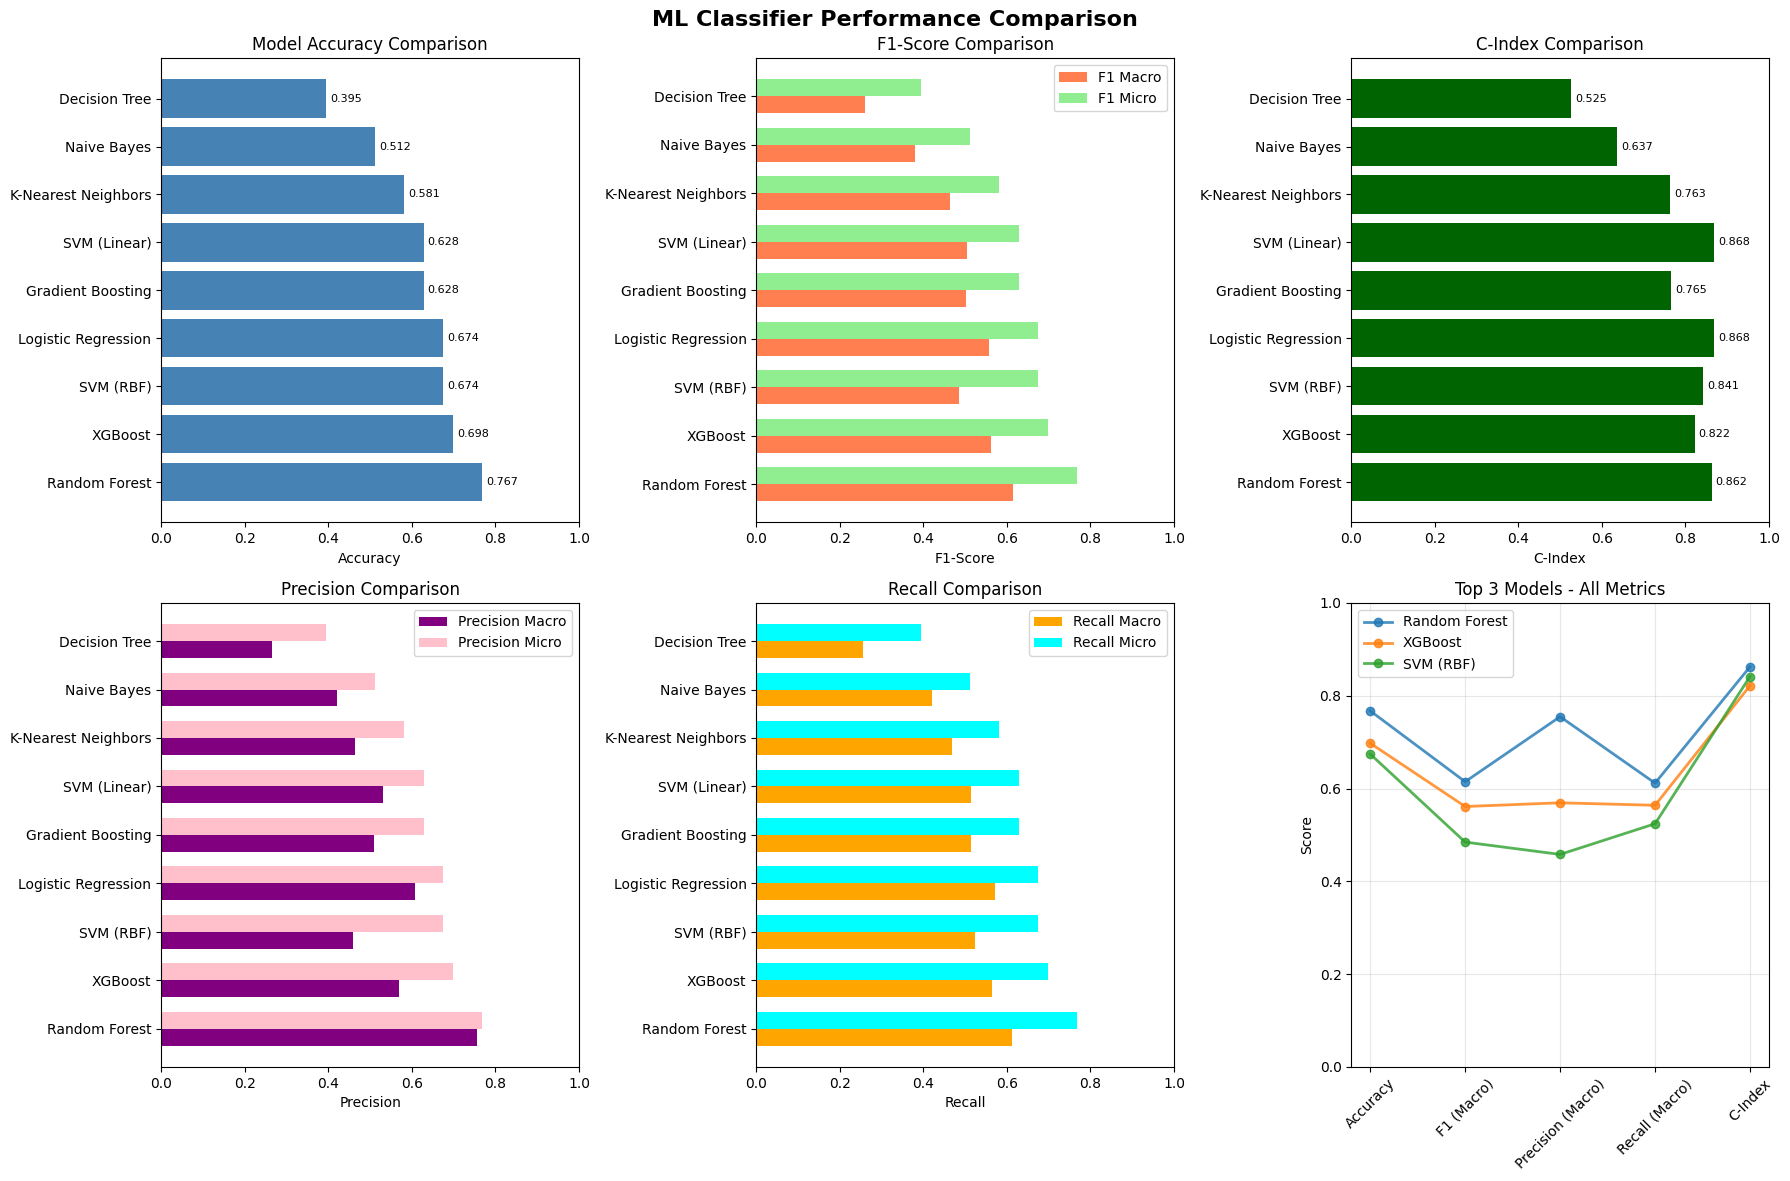

TRAINING & TESTING ENSEMBLE MODELS

🔹 Training Voting Ensemble (Soft)...
Training Random Forest...
Training Gradient Boosting...
Training SVM (RBF)...
Training SVM (Linear)...
Training Logistic Regression...
Training K-Nearest Neighbors...
Training Naive Bayes...
Training Decision Tree...
Training XGBoost...
🔹 Training Voting Ensemble (Hard)...
Training Random Forest...
Training Gradient Boosting...
Training SVM (RBF)...
Training SVM (Linear)...
Training Logistic Regression...
Training K-Nearest Neighbors...
Training Naive Bayes...
Training Decision Tree...
Training XGBoost...
🔹 Training Stacking Ensemble...
Generating meta-features using cross-validation...
Fitting base classifiers on full training data...
  Training Random Forest...
  Training Gradient Boosting...
  Training SVM (RBF)...
  Training SVM (Linear)...
  Training Logistic Regression...
  Training K-Nearest Neighbors...
  Training Naive Bayes...
  Training Decision Tree...
  Training XGBoost...
Fitting meta-classifier...
🔹

In [14]:

# ====================================================================
# CENTRALIZED DATA SPLITTING FOR ALL ML CLASSIFIERS
# ====================================================================
# This cell creates train/test splits used by all models
# Each disease subtype is split 80/20 independently, then merged
# to ensure consistent comparison across different classifiers
# ====================================================================

from sklearn.model_selection import train_test_split
import numpy as np

# Prepare features and labels
X = z_fused_labeled  # Fused latent features
y = labels  # Cancer subtype labels

print("="*70)
print("STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE")
print("="*70)
print(f"\n📊 Total samples: {len(X)}")
print(f"\n🔬 Disease subtype distribution:")

# Get unique disease subtypes
unique_subtypes = np.unique(y)
for subtype_idx in unique_subtypes:
    count = np.sum(y == subtype_idx)
    print(f"   - Subtype {subtype_idx}: {count} samples")

# ====================================================================
# Split each disease subtype 80/20, then merge
# ====================================================================
print(f"\n{'='*70}")
print("🔹 Train/Test Split - Stratified by Disease:")
print(f"{'='*70}")

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for subtype_idx in unique_subtypes:
    # Get samples for this subtype
    subtype_mask = (y == subtype_idx)
    X_subtype = X[subtype_mask]
    y_subtype = y[subtype_mask]
    
    # Split this subtype 80/20
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_subtype, y_subtype, test_size=0.2, random_state=42
    )
    
    X_train_list.append(X_train_sub)
    X_test_list.append(X_test_sub)
    y_train_list.append(y_train_sub)
    y_test_list.append(y_test_sub)
    
    print(f"   Subtype {subtype_idx}:")
    print(f"      Train: {len(X_train_sub)} samples ({len(X_train_sub)/len(X_subtype)*100:.1f}%)")
    print(f"      Test:  {len(X_test_sub)} samples ({len(X_test_sub)/len(X_subtype)*100:.1f}%)")

# Merge all subtypes
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print(f"\n📦 Merged splits:")
print(f"   - Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify distribution in train and test
print(f"\n📊 Disease distribution in splits:")
for subtype_idx in unique_subtypes:
    train_count = np.sum(y_train == subtype_idx)
    test_count = np.sum(y_test == subtype_idx)
    print(f"   Subtype {subtype_idx}:")
    print(f"      Train: {train_count} ({train_count/len(y_train)*100:.1f}%)")
    print(f"      Test:  {test_count} ({test_count/len(y_test)*100:.1f}%)")

print(f"\n✅ Data splits created successfully with stratification by disease!")
print(f"   - All ML classifiers will use: X_train, X_test, y_train, y_test")
print("="*70)

# ====================================================================
# Using MLClassifier module for ML Classification
# X_train, X_test, y_train, y_test are already created from above
# ====================================================================

from ml_classifier import MLClassifier, train_classifiers

print(f"✅ Using centralized data splits:")
print(f"   Training set size: {X_train.shape[0]}")
print(f"   Test set size: {X_test.shape[0]}")
print(f"   Training class distribution: {np.bincount(y_train.astype(int))}")
print(f"   Test class distribution: {np.bincount(y_test.astype(int))}")

# Train and evaluate all ML classifiers using MLClassifier module
ml_classifier = MLClassifier(random_state=42, include_xgboost=True)
results = ml_classifier.train_and_evaluate(X_train, X_test, y_train, y_test, verbose=True)

# Print results summary
ml_classifier.print_results()

# Get results dataframe for later use
results_df = ml_classifier.get_results_dataframe()

# Get the classifiers dictionary for compatibility with later cells
classifiers = ml_classifier.classifiers

# Visualize ML classification results using MLClassifier module
ml_classifier.plot_results(figsize=(18, 12))

# ====================================================================
# ENSEMBLE MODEL TESTING - Using ensemble.py
# ====================================================================
# Import required modules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import ensemble module
from ensemble import (
    VotingEnsemble,
    StackingEnsemble,
    WeightedAverageEnsemble,
    BaggingEnsemble,
    BoostingEnsemble,
    create_default_classifiers,
    evaluate_ensemble,
    evaluate_multiple_ensembles,
    print_ensemble_comparison,
    plot_ensemble_comparison
)

print("="*70)
print("TRAINING & TESTING ENSEMBLE MODELS")
print("="*70)

# Create base classifiers
base_classifiers = create_default_classifiers(random_state=42)

# Dictionary to store all trained ensembles
ensembles = {}

# 1. Voting Ensemble (Soft)
print("\n🔹 Training Voting Ensemble (Soft)...")
voting_soft = VotingEnsemble(create_default_classifiers(random_state=42), voting='soft')
voting_soft.fit(X_train, y_train)
ensembles['Voting (Soft)'] = voting_soft

# 2. Voting Ensemble (Hard)
print("🔹 Training Voting Ensemble (Hard)...")
voting_hard = VotingEnsemble(create_default_classifiers(random_state=42), voting='hard')
voting_hard.fit(X_train, y_train)
ensembles['Voting (Hard)'] = voting_hard

# 3. Stacking Ensemble
print("🔹 Training Stacking Ensemble...")
stacking = StackingEnsemble(
    create_default_classifiers(random_state=42),
    meta_classifier=LogisticRegression(max_iter=1000)
)
stacking.fit(X_train, y_train)
ensembles['Stacking'] = stacking

# 4. Weighted Average Ensemble
print("🔹 Training Weighted Average Ensemble...")
weighted = WeightedAverageEnsemble(
    create_default_classifiers(random_state=42),
    weights='accuracy'
)
weighted.fit(X_train, y_train)
ensembles['Weighted Average'] = weighted

# 5. Bagging Ensemble
print("🔹 Training Bagging Ensemble...")
bagging = BaggingEnsemble(
    base_classifier=RandomForestClassifier(n_estimators=50, random_state=42),
    n_estimators=10,
    random_state=42
)
bagging.fit(X_train, y_train)
ensembles['Bagging'] = bagging

# 6. Boosting Ensemble (AdaBoost)
print("🔹 Training Boosting Ensemble (AdaBoost)...")
boosting = BoostingEnsemble(n_estimators=50, random_state=42)
boosting.fit(X_train, y_train)
ensembles['Boosting (AdaBoost)'] = boosting

print("\n✅ All ensemble models trained successfully!")
print(f"   Total ensembles: {len(ensembles)}")

# ====================================================================
# EVALUATE ALL ENSEMBLE MODELS
# ====================================================================
print("\n" + "="*70)
print("ENSEMBLE MODEL SCORES & EVALUATION")
print("="*70)

# Evaluate all ensembles using ensemble.py's evaluate_multiple_ensembles function
ensemble_results = evaluate_multiple_ensembles(ensembles, X_test, y_test)

# Print formatted results table
print("\n📊 ENSEMBLE PERFORMANCE COMPARISON:")
print("-"*80)
print_ensemble_comparison(ensemble_results)

# Display results as DataFrame
print("\n📋 Results DataFrame:")
print(ensemble_results.to_string(index=False))

# Get best ensemble
best_idx = ensemble_results['Accuracy'].idxmax()
best_ensemble = ensemble_results.loc[best_idx]

print("\n" + "="*70)
print("🏆 BEST ENSEMBLE MODEL:")
print("="*70)
print(f"   Model:         {best_ensemble['Model']}")
print(f"   Accuracy:      {best_ensemble['Accuracy']:.4f}")
print(f"   F1 (Macro):    {best_ensemble['F1 (Macro)']:.4f}")
print(f"   F1 (Micro):    {best_ensemble['F1 (Micro)']:.4f}")
print(f"   C-Index:       {best_ensemble['C-Index']:.4f}")
